In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import sys

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from collections import defaultdict

if "../" not in sys.path:
  sys.path.append("../") 
from envs.blackjack import BlackjackEnv

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [3]:
def mc_prediction(policy, env, num_episodes, discount_factor=1.0):
    """
    Monte Carlo prediction algorithm. Calculates the value function
    for a given policy using sampling.

    Args:
        policy: A function that maps an observation to action probabilities.
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.

    Returns:
        A dictionary that maps from state -> value.
        The state is a tuple and the value is a float.
    """
    # The final value function
    V = defaultdict(float)

    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)

    for _ in xrange(num_episodes):
        s = env.reset()

        episode = []
        while True:
            a = policy(s)
            s_prime, reward, done, info = env.step(a)
            episode.append((s, reward))

            if done:
                break

            s = s_prime

        state_set = set([step[0] for step in episode])
        for s in state_set:
            first_i = next(i for i, step in enumerate(episode) if step[0] == s)
            G = sum(step[1] * (discount_factor ** i) for i, step in enumerate(episode[first_i:]))

            returns_sum[s] += G
            returns_count[s] += 1.0
            V[s] = returns_sum[s] / returns_count[s]

    return V

In [4]:
def sample_policy(observation):
    """
    A policy that sticks if the player score is > 20 and hits otherwise.
    """
    score, dealer_score, usable_ace = observation
    return 0 if score >= 20 else 1

In [5]:
def plot_value_function(V, title="Value Function"):
    """
    Plots the value function as a surface plot.
    """
    min_x = min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    # Find value for all (x, y) coordinates
    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))

    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player Sum')
        ax.set_ylabel('Dealer Showing')
        ax.set_zlabel('Value')
        ax.set_title(title)
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, Z_noace, "{} (No Usable Ace)".format(title))
    plot_surface(X, Y, Z_ace, "{} (Usable Ace)".format(title))

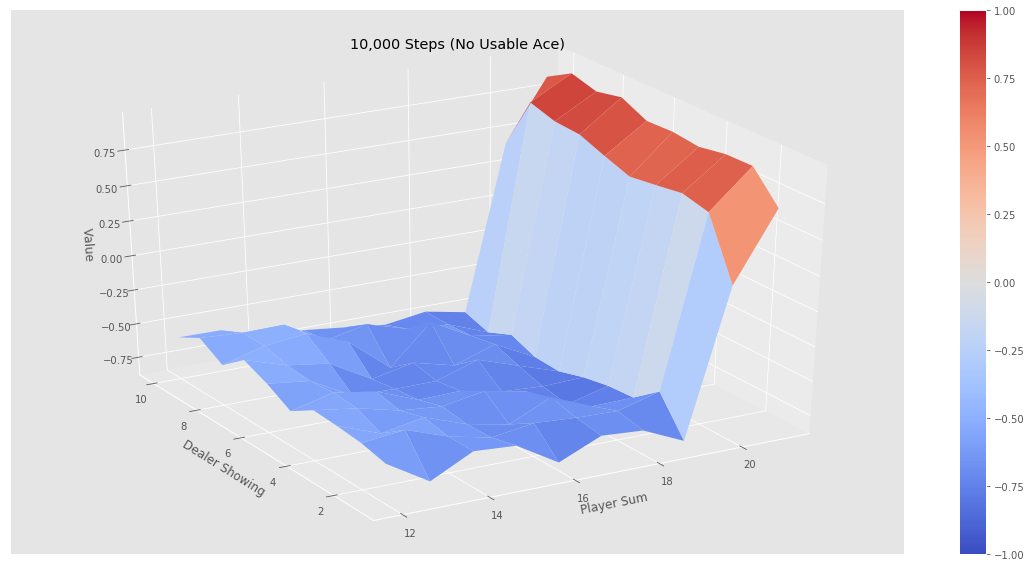

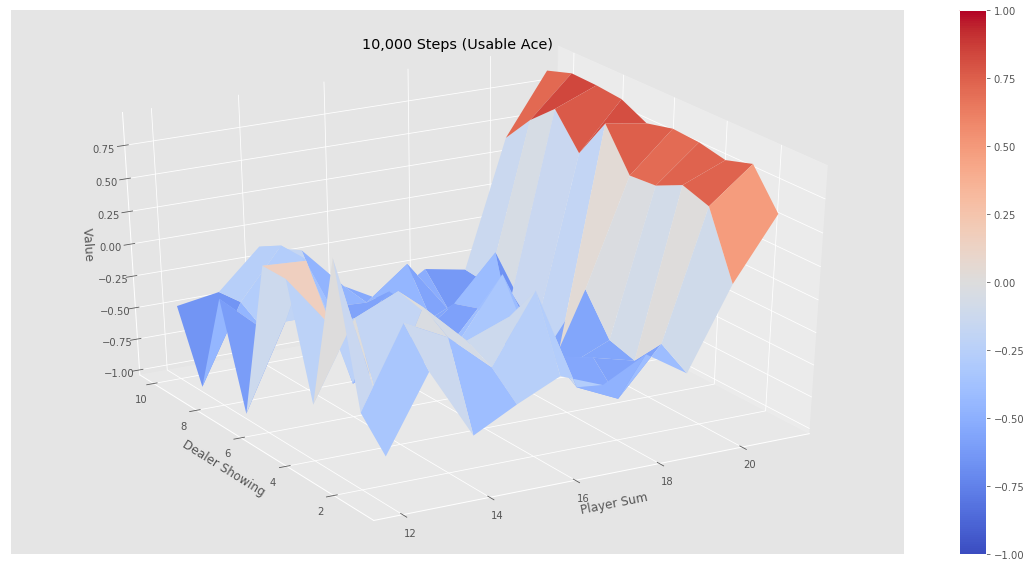

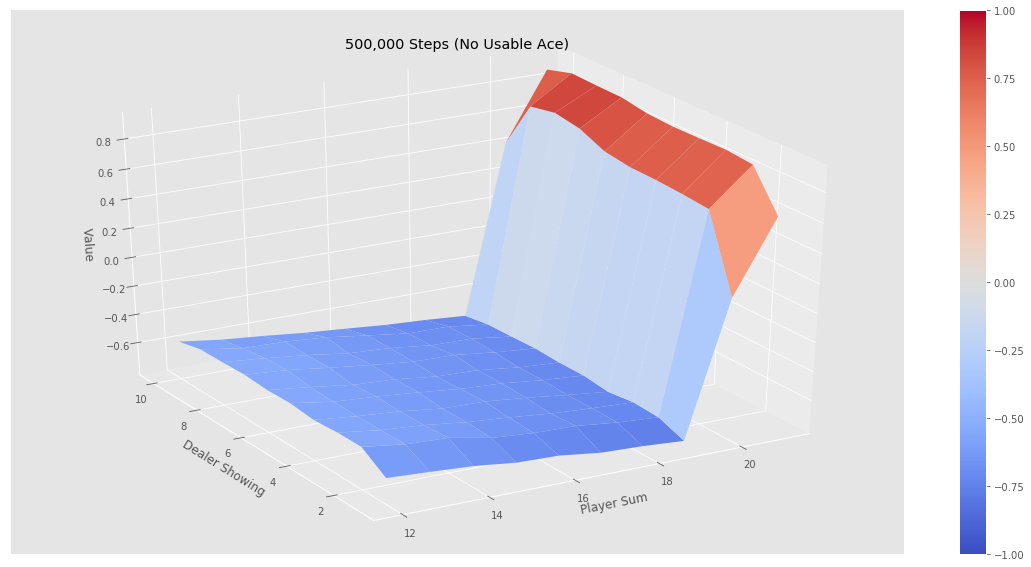

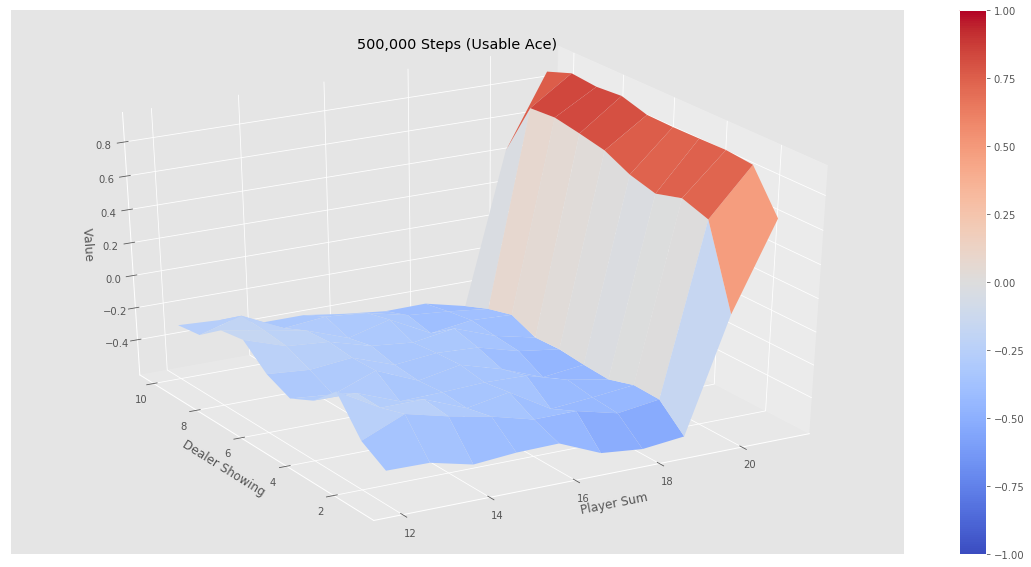

In [6]:
V_10k = mc_prediction(sample_policy, env, num_episodes=10000)
plot_value_function(V_10k, title="10,000 Steps")

V_500k = mc_prediction(sample_policy, env, num_episodes=500000)
plot_value_function(V_500k, title="500,000 Steps")